In [56]:
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pickle

path = os.getcwd()


In [58]:
#Import Data
(ds_train, ds_test), metadata = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True,
)

In [59]:
print('Number of training samples: %d' % tf.data.experimental.cardinality(ds_train))
print('Number of test samples: %d' % tf.data.experimental.cardinality(ds_test))
print('Number of classes: %d' % metadata.features['label'].num_classes)

Number of training samples: 12000
Number of test samples: 8580
Number of classes: 120


In [60]:
#The test set is pretty large, we merge some of it into the train set
ds_test = ds_test.shuffle(int(tf.data.experimental.cardinality(ds_test)), reshuffle_each_iteration=False)
ds_train = ds_train.concatenate(ds_test.take(5000))
ds_test = ds_test.skip(5000)

In [61]:
print('Number of training samples: %d' % tf.data.experimental.cardinality(ds_train))
print('Number of test samples: %d' % tf.data.experimental.cardinality(ds_test))
print('Number of classes: %d' % metadata.features['label'].num_classes)

Number of training samples: 17000
Number of test samples: 3580
Number of classes: 120


In [62]:
#Set Parameters
NUM_CLASSES = metadata.features['label'].num_classes
IMG_SIZE = 224
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

NUM_TRAINING = int(tf.data.experimental.cardinality(ds_train))
NUM_TEST = int(tf.data.experimental.cardinality(ds_test))

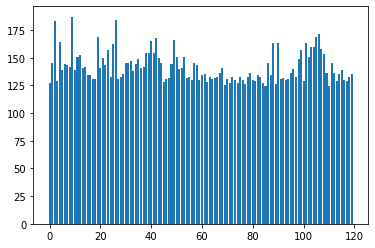

In [63]:
#Check how labels are distributed
vals = np.unique(np.fromiter(ds_train.map(lambda x, y: y), float), return_counts=True)

plt.figure()
plt.bar(vals[0], vals[1])
plt.show()

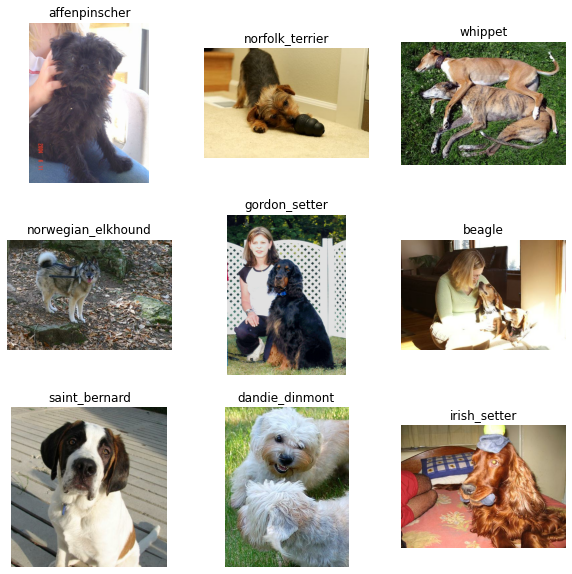

In [64]:
#Plot examples
get_name = metadata.features['label'].int2str

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(get_name(label).split('-')[1])
    plt.axis('off')

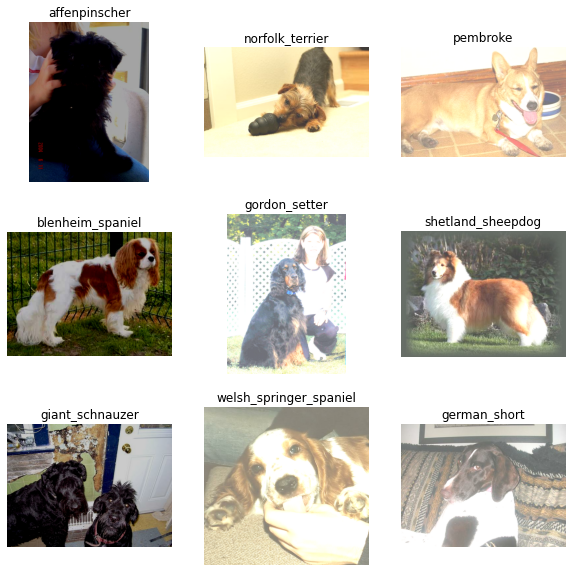

In [65]:
#Plot augmented examples
get_name = metadata.features['label'].int2str

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(utils.augment(image, label)[0])
    plt.title(get_name(label).split('-')[1])
    plt.axis('off')

In [66]:
#Preprocess the data
train = (ds_train
         .map(utils.preprocess, num_parallel_calls=AUTOTUNE)
         .map(utils.augment, num_parallel_calls=AUTOTUNE)
         .map(
             lambda image, label: (tf.keras.applications.nasnet.preprocess_input(image), label),
             num_parallel_calls=AUTOTUNE)
         .batch(64, drop_remainder=True)
         .prefetch(AUTOTUNE)
         .repeat()
        )
 
val = (ds_test
       .map(utils.preprocess, num_parallel_calls=AUTOTUNE)
       .map(
             lambda image, label: (tf.keras.applications.nasnet.preprocess_input(image), label),
             num_parallel_calls=AUTOTUNE)
       .cache()
       .batch(64, drop_remainder=True)
      )

In [ ]:
#Chose efficent model to run smoothly on low ressources.
base_model = tf.keras.applications.NASNetMobile(weights='imagenet', include_top=False)

#First train only the final layer
for layer in base_model.layers:
    layer.trainable = False


model = keras.Sequential([
        keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dropout(0.5),
        keras.layers.Flatten(),
        keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])


callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
]


lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.01, decay_steps=50, decay_rate=0.96, staircase=True
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.fit(train, 
          epochs=10, 
          callbacks=callbacks, 
          validation_data=val, 
          steps_per_epoch=NUM_TRAINING//BATCH_SIZE,
          validation_steps=NUM_TEST//BATCH_SIZE
         )

model.save(os.path.join(path, 'model_1'))

Epoch 1/10
265/265 [==============================] - 66s 249ms/step - loss: 1.1744 - accuracy: 0.7582 - val_loss: 0.7370 - val_accuracy: 0.8352
Epoch 2/10
265/265 [==============================] - 63s 239ms/step - loss: 1.0002 - accuracy: 0.8029 - val_loss: 0.6650 - val_accuracy: 0.8571
Epoch 3/10
265/265 [==============================] - 62s 234ms/step - loss: 0.8460 - accuracy: 0.8256 - val_loss: 0.5946 - val_accuracy: 0.8634
Epoch 4/10
265/265 [==============================] - 62s 235ms/step - loss: 0.7625 - accuracy: 0.8318 - val_loss: 0.5224 - val_accuracy: 0.8741
Epoch 5/10
265/265 [==============================] - 62s 233ms/step - loss: 0.6900 - accuracy: 0.8402 - val_loss: 0.4129 - val_accuracy: 0.8940
Epoch 6/10
265/265 [==============================] - 62s 233ms/step - loss: 0.5949 - accuracy: 0.8547 - val_loss: 0.4098 - val_accuracy: 0.8957
Epoch 7/10
265/265 [==============================] - 63s 237ms/step - loss: 0.5579 - accuracy: 0.8607 - val_loss: 0.3877 - val_ac

In [ ]:
base_model = keras.models.load_model(os.path.join(path, 'model_1'), compile=False)

for layer in base_model.layers:
    layer.trainable = True
    
for layer in base_model.layers[:2]:
    layer.trainable = False
    
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.001, decay_steps=50, decay_rate=0.96, staircase=True
)
    
    
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
]

base_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

base_model.fit(train, 
          epochs=10, 
          callbacks=callbacks, 
          validation_data=val, 
          steps_per_epoch=NUM_TRAINING//BATCH_SIZE,
          validation_steps=NUM_TEST//BATCH_SIZE
         )

base_model.save(os.path.join(path, 'model_2.h5'))

In [ ]:
breedList = [dog.split('-')[1].replace('_', ' ').title() for dog in metadata.features['label'].names]

with open('breedList.pkl', 'wb') as f:
    pickle.dump(breedList, f)

